# Аугментация изображений

Как и другие задачи, распознавание образов работает лучше всего на большом количестве разнообразных данных. Поэтому есть специальная техника для увеличения количества и разнообразия изображений путём применения к ним разных трансформаций — аугментация. 

Необходимая подготовка изображений состоит из двух этапов: 

- Масштабирования (англ. resize) — приведения всех изображений к одному размеру.
    
- Нормализации — приведения всех значений пикселей к одному интервалу.

## Масштабирование

Для распознавания рукописной цифры достаточно размера 28х28px, а для распознавания упаковки продукта — хотя бы 60х60px из-за деталей дизайна. Если на уменьшенной версии видны все детали, необходимые для распознавания объекта, то зачем тратить время и ресурсы на распознавание по оригинальному размеру?

В PyTorch реализован специальный объект для масштабирования изображений — torchvision.transforms.Resize. Его основные параметры:

- size — если указать одно число, то бóльшая сторона изображения будет приравнена к нему, а меньшая изменится пропорционально. К примеру, если для изображения 60х30 указать 30, то итоговое изображение будет иметь размер 30х15. Если указать два числа — например, (60, 60), то изображение будет растянуто так, чтобы соответствовать этому размеру.
  
- interpolation — опциональный, способ расчёта уменьшенной/увеличенной версии изображения. По умолчанию используется InterpolationMode.BILINEAR, то есть при уменьшении часть значений пикселей отбрасывается, при увеличении новые значения пикселей экстраполируются по имеющимся. Например, были пиксели [20, 40], после увеличения: [20, 30, 40].

```python
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import Resize

image = Image.open("car.png")
resize = Resize((60, 60))
resized_image = resize(image)
plt.imshow(resized_image)
```

Операции масштабирования неизбежно ухудшают качество — изображение становится более пиксельным. При уменьшении также отбрасывается часть информации.

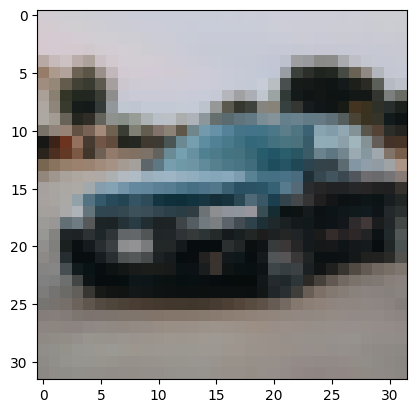

In [1]:
from ml_dl_experiments import settings
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import Resize

image = Image.open(settings.SOURCE_PATH + "ml_dl/CNN/car.png")
resize = Resize((32, 32))
resized_image = resize(image)
plt.imshow(resized_image)
plt.show()

## Нормализация

Нормализация для изображений — это приведение значений пикселей во всех каналах изображения к одному масштабу. В общем случае это нужно, чтобы градиентный спуск при обучении модели работал эффективнее. Однако есть и другая причина: фотографии в датасете обычно не сбалансированы с точки зрения цветов. В некоторых датасетах преобладают красные тона, в других — синие. 

Для изображений есть три основных способа нормализации:

1. Разделить все значения на 255. Так как пиксели всегда имеют значения в интервале от 0 до 255, после деления на 255 они гарантированно окажутся в интервале от 0 до 1 — нейросети отлично работают с ним. Значения пикселей изображений, загружаемых с помощью PIL, автоматически делятся на 255.
   
2. Вычесть из всех значений 128 (предположительное среднее) и разделить на 128 (предположительное стандартное отклонение). Это приведёт данные к интервалу от -1 до 1, тоже отличный вариант для обучения нейросетей. Так как предположительное и реальное среднее могут отличаться как по датасету в целом, так и по конкретному изображению, итоговое распределение значений необязательно будет иметь среднее 0 и стандартное отклонение 1.
   
3. Поканально вычесть среднее и разделить результат на стандартное отклонение. Для больших датасетов эти метрики можно не предполагать, а рассчитать по каждому каналу всех изображений. В результате значения будут иметь среднее 0, стандартное отклонение около 1 — идеальный вариант для обучения нейросетей. Для известных датасетов это значение можно найти в сети, к примеру, для MNIST после деления всех пикселей на 255, среднее 0.1307, стандартное отклонение 0.3081.

```python
from torchvision.transforms.v2 import Normalize
from torchvision.transforms.functional import to_tensor
from PIL import Image


image = Image.open("car.jpg")
# Нормализация не работает с PIL, только с pyTorch тензорами
image_tensor = to_tensor(image)

# Первый способ, однако загруженное с помощью PIL изображение 
# уже имеет значения в интервале [0,1]
# image_tensor /= 255  

# Второй способ
# Вычесть примерное среднее (0.5 для интервала [0, 1]),
# Примерное std - так же 0.5
normalize = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
normalized_image = normalize(image_tensor)

# Третий способ
# Использовать среднее и std из конкретного датасета
# В этом примере - из датасета ImageNet
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalized_image = normalize(image_tensor)
```

## Аугментация

Для обучения нужны более обширные и разнообразные данные. Аугментация — это увеличение количества и разнообразия данных в датасете. Под разнообразием имеются в виду как разные объекты, так и искажения изображений, свойственные реалистичным фотографиям, к которым нейросеть должна быть готова, например:

- засветы;
 
- искажения цвета;
  
- неправильная ориентация изображения (альбомная/книжная);
  
- отражения.

Это связано с тем, что CNN склонны отдавать предпочтение текстурам, нежели формам, при принятии решения. 
Поэтому обычно в датасете размещается достаточно примеров объекта разных расцветок, чтобы приучить нейросеть реагировать на форму.

У аугментации есть важный принцип — нельзя менять изображение так, чтобы оно потеряло информацию, необходимую для распознавания.

### Инструменты для аугментации

Аугментация отличается от обычного изменения изображения тем, что она должна быть разной для каждого изображения. К примеру, если сделать все изображения на 10% более красными, то нейросеть не научится игнорировать незначительные изменения цвета. Она научится проводить обратную операцию — делать их менее красными, а затем работать с ними как обычно. Поэтому важно, чтобы к каждому изображению применялся некоторый случайный набор случайных трансформаций.

При аугментации для любой трансформации задаются два параметра:

- Вероятность срабатывания. Например, 0.5 значит, что эта трансформация будет применена в среднем к каждому второму изображению в датасете.
  
- Диапазон возможных значений параметра трансформации. Например, [90, 180, 270] — список возможных значений углов поворота, из которых будет случайным образом выбрано одно для конкретного изображения. Или [0.9, 1.1] — диапазон изменения контрастности (от -10% до +10%), из которого будет случайно выбрано конкретное значение.


**Изменение контрастности и тона**

Это способ имитировать засвеченные и слишком тёмные фотографии. Изменение тона — имитация искажений сенсора камеры, когда все объекты имеют не совсем такой же цвет, как в реальности. Эти трансформации называются фотометрическими и вместе с другими подобными реализованы в PyTorch как `torchvision.transforms.v2.RandomPhotometricDistort`. Для настройки вышеописанных трансформаций используются параметры:

- p — вероятность применения каждой трансформации независимо от других. По умолчанию 0.5.
  
- contrast — диапазон значений, из которых будет выбрано, насколько изменить контрастность изображения. По умолчанию [0.5, 1.5] — от 50% до 150%. Чем больше это значение, тем контрастнее будет изображение, то есть тёмные пиксели станут ещё темнее, а светлые — ещё светлее.
  
- hue — диапазон значений, из которых будет выбрано, на сколько изменить оттенок цвета изображения. Максимальный интервал — [-0.5, 0.5], то есть изменение на 50% в одну сторону спектра либо в другую. Важно, что для этой трансформации значения пикселей должны быть неотрицательными, например, нормализованными к диапазону [0, 1] или ненормализованными.

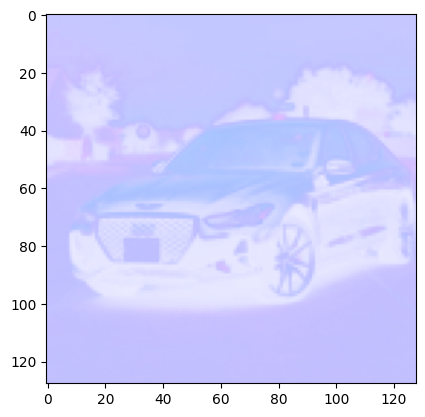

In [7]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import Resize
from torchvision.transforms.v2 import RandomPhotometricDistort

image = Image.open(settings.SOURCE_PATH + "ml_dl/CNN/car.png")
resize = Resize((128, 128))
resized_image = resize(image)

# Аугментация
photometric_distort = RandomPhotometricDistort(p=0.5, 
                                               contrast=[0.8, 1.2], 
                                               hue=[-0.1, 0.1])

distorted_image = photometric_distort(resized_image)

plt.imshow(distorted_image)

**Отражение**
Способ показать модели, что объект не меняет свой класс, если отразить его по вертикали или горизонтали.

Аугментация отражением реализована в PyTorch двумя классами: `torchvision.transforms.v2.RandomHorizonalFlip` и `torchvision.transforms.v2.RandomVerticalFlip` для отражений по горизонтальной и вертикальной оси соответственно. Обе принимают на вход только один параметр — вероятность срабатывания p.

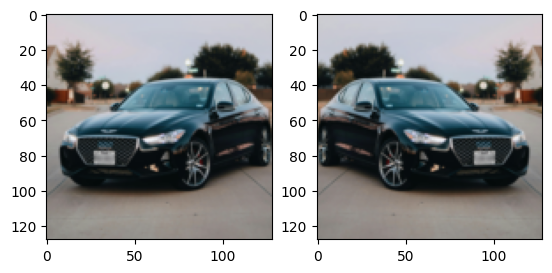

In [8]:
from torchvision.transforms.v2 import RandomHorizontalFlip, Resize

resize = Resize((128, 128))
resized_image = resize(image)

# Аугментация
flip = RandomHorizontalFlip(p=0.5)
distorted_image = flip(resized_image)

# Визуализация результата
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(resized_image)

plt.subplot(1, 2, 2)
plt.imshow(distorted_image)

**Поворот**
Поворот изображения вокруг его центра. Реализована в PyTorch как `torchvision.transforms.v2.RandomRotation`, которая принимает на вход параметр degrees. Его можно указать как интервал в градусах — например, [-180, 90], или как число — например, 180, это будет равноценно [-180, 180]. Число отвечает за вращение по и против часовой стрелки. В отличие от предыдущих трансформаций, для поворота нельзя настроить вероятность срабатывания — он срабатывает в любом случае, но со случайно выбранным из интервала углом поворота.

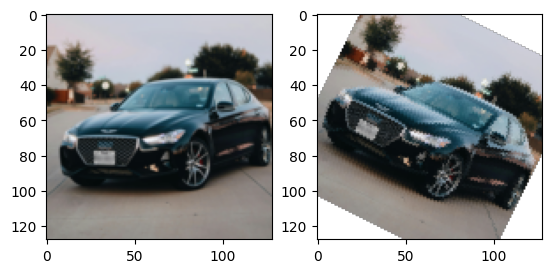

In [9]:
from torchvision.transforms.v2 import RandomRotation

resize = Resize((128, 128))
resized_image = resize(image)

rotate = RandomRotation((-45, 45))
distorted_image = rotate(resized_image)

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(resized_image)

plt.subplot(1, 2, 2)
plt.imshow(distorted_image)

**Аугментация для датасета**

Разобравшись с тем, как аугментации работают для отдельных изображений, рассмотрим, как применить их для датасета. Так как разнообразие повышается, если к каждому изображению применяется несколько трансформаций, для датасета собирается пайплайн — несколько трансформаций, которые будут осуществлены последовательно. 


100%|██████████| 26.4M/26.4M [00:40<00:00, 650kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 645kB/s]
100%|██████████| 4.42M/4.42M [00:04<00:00, 1.03MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 32.6MB/s]


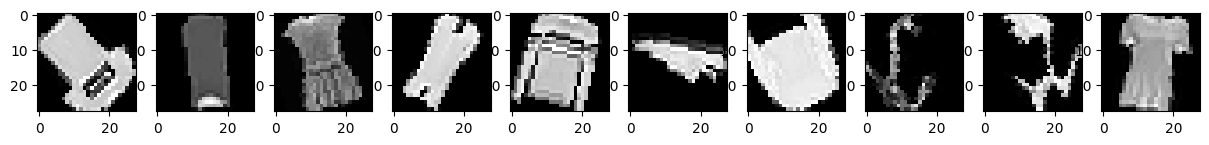

In [10]:
from torchvision.transforms.v2 import RandomRotation, RandomPhotometricDistort, \
RandomHorizontalFlip, RandomVerticalFlip, Compose
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt

transforms = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomPhotometricDistort(p=0.5,
                             contrast=[0.8, 1.2],
                             hue=[-0.1, 0.1]),
    RandomRotation([-45, 45])
])

# Указание списка трансформаций для датасета
dataset = FashionMNIST(root='data/', download=True, transform=transforms)

# Визуализация применения аугментации
fig = plt.figure(figsize=(15,5))
for index in range (1, 11):
    image, label = dataset[index]
    plt.subplot(1, 10, index)
    plt.imshow(image, cmap='gray')

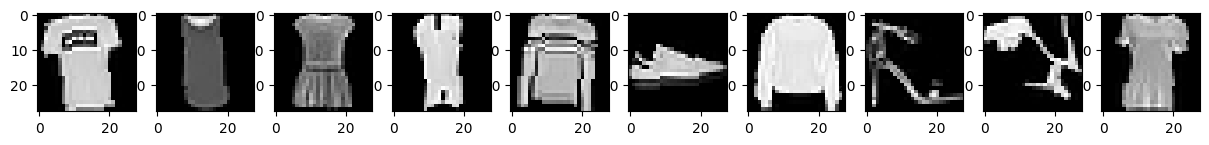

In [15]:
transforms = Compose([
    RandomHorizontalFlip(p=0.3),
    RandomVerticalFlip(p=0.3),
    RandomRotation([-10, 10])
])

dataset = FashionMNIST(root=settings.SOURCE_PATH+"datasets/", download=False, transform=transforms)

fig = plt.figure(figsize=(15,5))
for index in range (1, 11):
    image, label = dataset[index]
    plt.subplot(1, 10, index)
    plt.imshow(image, cmap='gray')


- Масштабирование. Необходимая операция для того, чтобы скорректировать изображения в датасете под вход модели.
  
- Нормализация изображения. Как и прочие входные данные, изображения обычно проходят через эту операцию, чтобы ускорить обучение модели с помощью градиентного спуска.
  
- Аугментация. Способ наращивания объёма и разнообразия датасета.

# Transfer Learning

Из-за большого количества параметров моделей и универсальности первого этапа распознавания — извлечения признаков из изображения — CNN редко обучают с нуля. Обычно используют технику под названием Transfer Learning, которая позволяет перенести «знания» нейросети из одной задачи в другую.

- Transfer Learning — техника, позволяющая не обучать модели, а использовать полностью или частично готовые.
    
- Feature Extraction — процесс извлечения признаков из изображения, который выполняется в каждой задаче компьютерного зрения.
    
- Fine-tuning — метод корректировки модели, обученной для других задач, чтобы использовать её в собственных.

Архитектуры CNN обычно состоят из двух частей: `свёрточной` и той, что нужна для решения задачи. Свёрточная часть используется для извлечения признаков из изображения. Она есть в любой архитектуре: в компьютерном зрении всегда необходимо извлечь признаки из изображения, вне зависимости от типа задачи.

Процесс извлечения признаков называется `Feature Extraction`, а свёрточные части архитектур, которые для этого используются, — `Feature Extractor`, или сокращённо `FE`. 

Все ранее рассмотренные архитектуры — LeNet, AlexNet, VGG, ResNet, DenseNet — можно рассматривать как Feature Extractor + один или несколько полносвязных слоёв для задачи классификации.

`Transfer Learning` — это техника, позволяющая применять модель, обученную для одной задачи, в решении другой. Технически это реализуется так:

 - Обучить универсальную CNN для классификации (например, на 1000 классов ImageNet).
 
 - Удалить последние полносвязные слои из универсальной CNN, чтобы осталась только свёрточная часть.
 
 - Добавить необходимые для решения конкретной задачи полносвязные слои, например, на 10 нейронов для распознавания рукописных цифр.
 
 - Дообучить только последние полносвязные слои уже на датасете для решения конкретной задачи распознавания цифр.

Такой подход имеет ряд преимуществ:

- Модель обучается быстрее, так как большая часть параметров уже известна — осталось только настроить веса для полносвязной части.

- Так как обучаемых параметров немного, можно дообучать модель на небольшом датасете и всё равно получить хороший результат.

- Модель имеет большую обобщающую способность за счёт того, что обучена на разнообразных признаках. Её диапазон знаний о том, какими вообще могут быть признаки, шире, чем у узкоспециализированных моделей.

Процесс дообучения предобученной модели вариативен: можно обучать только последние слои, можно немного корректировать все, можно обучать все, кроме первых двух и так далее. Этот процесс имеет собственное название — `Fine-tuning`, или тюнинг модели, эдакая доводка весов под решаемую задачу.

## Fine-tuning

Процесс Fine-tuning вариативен:

- **Обучать только добавленные полносвязные слои.** Этот вариант используется, когда решаемая задача — это часть той, на которой модель предобучена.

- **Дообучать все слои.** В случаях, когда даже некоторые базовые признаки в решаемой задаче значительно отличаются от той, на которой модель предобучена.

- **Дообучать все слои, кроме первых 2-3.** Для тех случаев, когда базовые, простейшие признаки извлекаются правильно, а дальше формируют не те признаки верхнего уровня, которые нужны для решения конкретной задачи.

Чтобы во время обучения подбирать не все веса, а только часть, используется заморозка весов.

## Заморозка весов

**Заморозка** — это директива для процесса обучения, которой помечают слои, веса которых не должны изменяться.

Для того чтобы заморозить слои на время обучения, используется директива `requires_grad=False`. Она указывается для конкретных параметров модели. 

In [16]:
from matplotlib.font_manager import weight_dict
import torchvision
from torchvision.models import resnet50

model = resnet50(weights='IMAGENET1K_V2')

print('Model params: ', model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ollldman/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:43<00:00, 2.38MB/s]

Model params:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 

Допустим, нужно дообучить эту модель на все те же 1000 классов, но некоторые будут немного изменены. Значит, достаточно обучить только последний слой fc, так как он отвечает за классификацию. Остальные можно заморозить. Для этого сначала замораживаются все веса модели.

```python
for param in model.parameters():
    param.requires_grad = False
```

Далее размораживаются те, которые нужно скорректировать, — к примеру, слой fc.

```python
for param in model.fc.parameters():
    param.requires_grad = True
```

In [3]:
from torchvision.models import efficientnet_b0
from torchsummary import summary
import torchvision

model = efficientnet_b0(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
for param in model.classifier.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Подбор скорости обучения

При `Fine-tuning` используется небольшая скорость обучения. Если обучение велось на скорости `0.01-0.001`, то для дообучения вполне можно использовать `0.0001-0.00001`.

# Применение предобученных моделей


## Поиск предобученных моделей
Для использования предобученной модели, нужен файл с её весами. Разработчики и академическое сообщество делятся ими, поэтому обычно подходящие веса можно найти в интернете. Популярных площадок для поиска предобученных моделей три: 

- PyTorch. В этот фреймворк входят популярные архитектуры CNN и веса для них, обычно предобученные на ImageNet.

- HuggingFace — платформа, на которой разработчики и исследователи делятся новейшими разработками. Так как это общая площадка, не все модели подходят для PyTorch, некоторые лицензированы и могут применяться только в некоммерческих проектах. У каждой модели есть своя карточка, на которой описана вся необходимая информация о её использовании, способе загрузки и прочее. Преимущество платформы — новейшие модели появляются здесь значительно быстрее, чем в основном PyTorch. **Имеет выраженный фокус на языковых моделях.**
    
- Kaggle — платформа для соревновательного ML, где, как и на Hugging Face, выкладывают современные модели. Kaggle отличается тем, что помимо моделей на нём есть и примеры кода, и датасеты. Также Kaggle не специализируется на каких-то определённых моделях.

Этот список не исчерпывающий — часто авторы статей размещают файлы моделей и коды архитектур в своих репозиториях на GitHub или на страницах блогов. Поэтому к вопросу поиска моделей с непопулярными архитектурами или обученных на специфической предметной области нужно относиться креативно.

## Форматы хранения

PyTorch модели обычно хранятся как файлы формата .pt или .pth.

Они содержат предобученные веса, которые можно загрузить в объявленную в коде архитектуру модели. Помимо весов они могут содержать и иную информацию, например, гиперпараметры и текущие параметры оптимизатора, если модель нужно загрузить для продолжения обучения. Однако чаще всего предоставляются только веса. 

Модель может храниться в формате .bin, то есть как обычный бинарный файл.

## Загрузка предобученной нейросети

Процесс загрузки модели MobileNetV3-small, найденной на Kaggle, с помощью библиотеки timm:

- На странице модели выбрать нужную версию в списке. Так как нужна MobileNetV3-small, в списке выбирается её минимальная версия — tf_mobilenetv3_small_minimal_100.
  
- Скачать модель в виде архива .tar.gz, распаковать, получить файл tf_mobilenetv3_small_minimal_100-922a7843.pth, запомнить путь к нему — это будет параметр checkpoint_path.
  
- Выполнить код, подставив checkpoint_path:

In [2]:
import timm
from torchsummary import summary
from ml_dl_experiments import settings


model = timm.create_model(model_name="tf_mobilenetv3_small_100",checkpoint_path=settings.SOURCE_PATH + "ml_dl/models/MobileNetv3-small-100/tf_mobilenetv3_small_100.pth")
summary(model, input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 16, 112, 112]             432
          Identity-2         [-1, 16, 112, 112]               0
         Hardswish-3         [-1, 16, 112, 112]               0
    BatchNormAct2d-4         [-1, 16, 112, 112]              32
        Conv2dSame-5           [-1, 16, 56, 56]             144
          Identity-6           [-1, 16, 56, 56]               0
              ReLU-7           [-1, 16, 56, 56]               0
    BatchNormAct2d-8           [-1, 16, 56, 56]              32
          Identity-9           [-1, 16, 56, 56]               0
           Conv2d-10              [-1, 8, 1, 1]             136
             ReLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 16, 1, 1]             144
      Hardsigmoid-13             [-1, 16, 1, 1]               0
    SqueezeExcite-14           [-1, 16,

In [9]:
from PIL import Image
image = Image.open(settings.SOURCE_PATH+"ml_dl/CNN/cat.webp").convert("RGB")
from torchvision.transforms.v2 import Resize, ToImage, ToDtype, Compose
import torch
transform = Compose(
    [
        Resize((224, 224)),
        ToImage(),
        ToDtype(torch.float32, scale=True)
    ]
)

transformed_image = transform(image).unsqueeze(0)
transformed_image.shape

torch.Size([1, 3, 224, 224])

In [10]:
model.eval()

outputs = model(transformed_image)

In [11]:
result = outputs.softmax(dim=1)
top5_probabilities, top5_class_indices = torch.topk(result * 100, k=5)
top5_probabilities, top5_class_indices

(tensor([[66.0577, 11.7926,  3.7715,  3.0602,  1.0891]],
        grad_fn=<TopkBackward0>),
 tensor([[282, 285, 281, 283, 291]]))

Процесс загрузки модели MobileViT-small, найденной на Hugging Face, с помощью фреймворка transformers.

Порядок почти всегда одинаковый:

- Импорт необходимой библиотеки. Перед этим их нужно установить, к примеру, с помощью pip install.
  
- Скачивание модели: либо автоматическое, как во втором примере, либо вручную с сайта ресурса, как в первом.
  
- Создание архитектуры модели с помощью встроенного инструмента фреймворка или библиотеки (create_model, AutoModelForImageClassification.from_pretrained) и загрузка в неё весов из переданного файла или пути скачивания.
    
- Получение готовой к работе модели.

- Опционально — дозагрузка дополнительных компонентов для конкретной модели, например, функции для предобработки входных данных — processor. В коде его использование выглядит так (processed_images — готовые к передаче в модель изображения, images — исходные):

```python
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")
model = AutoModelForImageClassification.from_pretrained("apple/mobilevit-small")

processed_images = processor(images)
```
В карточках моделей описываются возможные изменения в этом процессе, поэтому можно положиться на инструкции, приложенные авторами самой модели.

К модели `MobileNetV3-small` авторы добавили сценарий использования, в котором вместо `AutoModelForImageClassification` используется более точный класс для архитектуры модели — `MobileViTForImageClassification`, а также показали, как получить предсказания модели (predicted_class_idx) и как использовать их модель как FE.

```python
from transformers import MobileViTFeatureExtractor, MobileViTForImageClassification
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/mobilevit-small")
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")

inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
```

- Режим обучения: model.train().
  
- Режим использования: model.eval().

## Доработка архитектуры под задачу

Рассмотрим, как редактировать архитектуру готовой модели под себя.

### Шаг 1. Загрузить модель и предобученные веса к ней. 

Для этого снова воспользуемся фреймворком PyTorch:

```py
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small(weights='IMAGENET1K_V1')
```

### Шаг 2. Cделать вызов print(model), чтобы оценить, какие слои придётся менять. 

Так как свёрточная часть универсальна от задачи к задаче, присматриваемся только к последним — полносвязным — слоям:

```py
print(model)
```
### Шаг 3. Готовим замену для classifier. 

Так как у нас будет 2 класса, можно сделать точно такую же архитектуру, но заменить в последнем полносвязном слое 1000 нейронов на 1. После него добавить активацию nn.Sigmoid, и тогда получится бинарный классификатор.

```py
import torch.nn as nn

binary_classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1024, out_features=1, bias=True),
    nn.Sigmoid()
)
```

### Шаг 4. Заменяем classifier, который был в изначальной модели, на наш новый binary_classifier.

```py
model.classifier = binary_classifier
```